In [1]:
## ONLY NEEDED IF USING VSCODE

# import os

# # Enter experiment folder name
# exp = 'Control'

# # Get the current user's username
# username = os.environ['USER']

# # # Change the directory
# # os.chdir(f'/scratch/{username}/Model/{exp}')

# # Verify the current directory
# print("Current Directory:", os.getcwd())

In [2]:
import pathlib
import platform
import subprocess
import warnings

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_harmonics as th
import torch_harmonics.distributed as dist
import xarray as xr
import xesmf as xe

from subs1_utils import *
from subs1_utils import precompute_latitudes, bscst


warnings.filterwarnings("ignore")

With this model, you will be able to simulate perpetual conditions matching the climatology of your choice. While there is chaos and natural variability that will occur, this simple model works by always nudging the conditions back to the background state of your choice.

In [3]:
# Select the monthly climatology you wish to use as the background state
# Jan = 1 and Dec = 12
month=2

month-=1 # change to Python 0-based indexing

In [4]:
### Define Spectral Truncation Desired and Consistent
###    Gausian Grid
zw = 42
kmax = 26

In [5]:
# Check value for kmax.
if kmax!=11 and kmax!=26:
    raise Exception("Unexpected value for kmax")

# Check value for zw.
# Afterwards, set mw, jmax, and imax values based on the value given to zw.
match zw:
    case 42:
        mw = zw
        jmax = 64
        imax = 128
    case 63:
        mw = zw
        jmax = 96
        imax = 192
    case 124:
        mw = zw
        jmax = 188
        imax = 376
    case _:
        raise Exception("Unexpected value for zw")

In [6]:
# Setup necessary element for interpolation onto model Gaussian Grid
# Get the Gaussian latitudes on equally spaced longitudes (xr.dataset)
cost_lg, wlg, lats = precompute_latitudes(jmax)
lats = 90-180*lats/(np.pi)
lons = np.linspace(0.0,360.0-360.0/imax,imax)
dlatlon = xr.Dataset({"lat": lats, "lon": lons})

# Instantiate  grid to spectral (dsht) and spectral to grid (disht) transforms
#
vsht = th.RealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
dsht = dist.DistributedRealSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
disht = dist.DistributedInverseRealSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
dvsht = dist.DistributedRealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
divsht = dist.DistributedInverseRealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)

# Grab the topography data
In these next steps, we'll retrieve a topography file from the web and reformat it for the model.

In [7]:
url_topo = 'http://research.jisao.washington.edu/data_sets/elevation/elev.0.75-deg.nc'
ds_topo = xr.open_dataset(url_topo + '#mode=bytes', decode_times = False) # adding #mode=bytes because netcdf4 non-opendap URLrequeriment
del ds_topo['time']
data = ds_topo.data.squeeze()
data

<xarray.DataArray 'data' (lat: 241, lon: 480)> Size: 925kB
[115680 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 2kB 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * lon      (lon) float64 4kB 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
Attributes:
    units:      m
    long_name:  m

Let's take a look at the file.

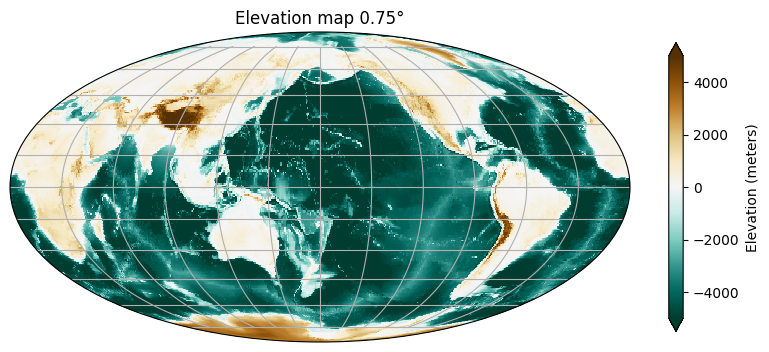

In [8]:
lon = np.linspace(-np.pi, np.pi, data.shape[1])
lat = np.linspace(np.pi/2., -np.pi/2., data.shape[0])
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
cs = ax.pcolormesh(Lon, Lat, data, cmap='BrBG_r', vmin=-5000, vmax=5000)
ax.set_title("Elevation map 0.75°")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
cbar = fig.colorbar(cs, ax=ax, shrink=0.75, extend='both')
cbar.set_label('Elevation (meters)')
plt.show()

In [9]:
regridder_topog = xe.Regridder(data, dlatlon,'bilinear')

In [10]:
topog_gg = regridder_topog(data)*9.8

Now, we'll zero out everything below sea level and restructure the data to be read in by the model.

In [11]:
topog_gg_dev = torch.from_numpy(np.where(topog_gg < 0.0, 0.0, topog_gg))
coeffs = dsht(topog_gg_dev)
topog_gg_r = disht(coeffs)

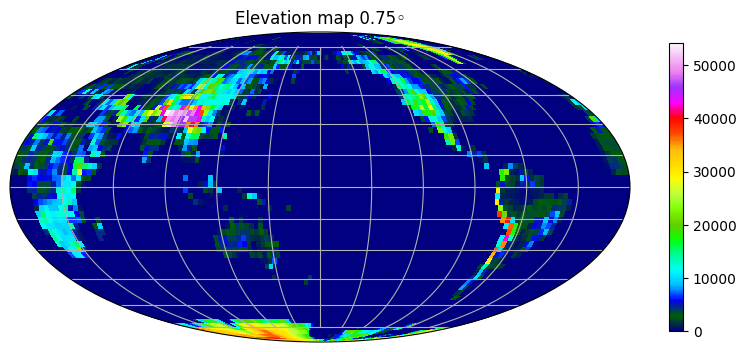

In [12]:
lon = np.linspace(-np.pi, np.pi, topog_gg_dev.shape[1])
lat = np.linspace(np.pi/2., -np.pi/2., topog_gg_dev.shape[0])
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
cs = ax.pcolormesh(Lon, Lat, topog_gg_dev, cmap='gist_ncar')
ax.set_title("Elevation map 0.75◦")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(cs, ax=ax, shrink=0.75)
plt.show()

In [13]:
# Write out the spectral coefficients for topography to be read by
# the AGCM as a pickle file
#
torch.save(coeffs,'topog.spectral.pt')

# Grab the temperature data

In [14]:
# Surface temp used to derive 3-D temperature field for
# Newtonian Relaxation
#
#
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/surface/air.sig995.mon.mean.nc'
Dtemp = xr.open_dataset(ftemp,autoclose=True)
Dtemp
#
# Field above is monthly 0.995 sigma level data
# 

<xarray.Dataset> Size: 39MB
Dimensions:  (lon: 144, time: 921, lat: 73)
Coordinates:
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2024-09-01
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 39MB ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                        Model
    Conventions:                     COARDS
    NCO:                             20121012
    history:                         Thu May  4 20:11:16 2000: ncrcat -d time...
    title:                           monthly mean air.sig995 from the NCEP Re...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.8.20
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

Let's take a peak at the data

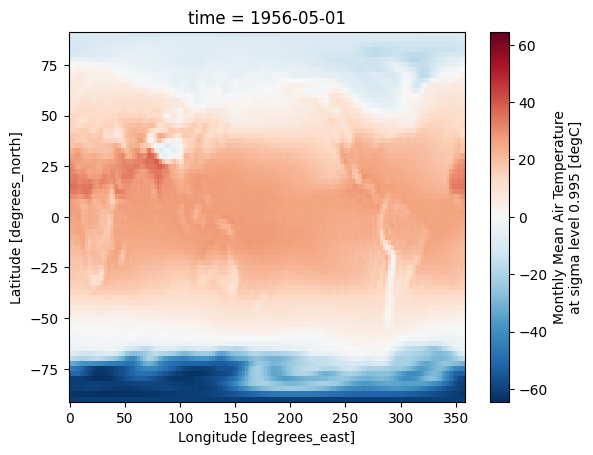

In [15]:
Dtemp.air[100,:,:].plot()

In [16]:
# Calculate Climatology
#
tsurf_climo = Dtemp.air.groupby('time.month').mean(dim='time')
tsurf_climo

<xarray.DataArray 'air' (month: 12, lat: 73, lon: 144)> Size: 505kB
array([[[-29.753878, -29.753878, -29.753878, ..., -29.753878,
         -29.753878, -29.753878],
        [-30.736717, -30.700539, -30.665993, ..., -30.848183,
         -30.809933, -30.773293],
        [-30.598063, -30.310413, -30.022888, ..., -31.403683,
         -31.151155, -30.880733],
        ...,
        [-20.064796, -19.908844, -19.757248, ..., -20.399616,
         -20.328592, -20.210745],
        [-20.829105, -20.852863, -20.87231 , ..., -20.70426 ,
         -20.756655, -20.797415],
        [-22.556171, -22.556171, -22.556171, ..., -22.556171,
         -22.556171, -22.556171]],

       [[-30.165087, -30.165087, -30.165087, ..., -30.165087,
         -30.165087, -30.165087],
        [-30.979965, -30.927128, -30.874712, ..., -31.14396 ,
         -31.088734, -31.034279],
        [-30.70556 , -30.388002, -30.07117 , ..., -31.591257,
         -31.313969, -31.017061],
...
        [-30.13268 , -29.9947  , -29.854986, ..., -30.345032,
         -30.326548, -30.249332],
        [-30.596722, -30.638447, -30.670639, ..., -30.396378,
         -30.477798, -30.54442 ],
        [-31.279789, -31.279789, -31.279789, ..., -31.279789,
         -31.279789, -31.279789]],

       [[-28.38714 , -28.38714 , -28.38714 , ..., -28.38714 ,
         -28.38714 , -28.38714 ],
        [-29.400387, -29.36855 , -29.336304, ..., -29.493967,
         -29.462557, -29.4318  ],
        [-29.453527, -29.190636, -28.923864, ..., -30.15396 ,
         -29.940481, -29.705297],
        ...,
        [-19.240599, -19.109182, -18.987726, ..., -19.526169,
         -19.465048, -19.364466],
        [-20.373526, -20.410955, -20.444426, ..., -20.21308 ,
         -20.276052, -20.328634],
        [-22.167686, -22.167686, -22.167686, ..., -22.167686,
         -22.167686, -22.167686]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     Monthly Mean Air Temperature at sigma level 0.995
    valid_range:   [-2000.  2000.]
    units:         degC
    precision:     1
    var_desc:      Air Temperature
    statistic:     Mean
    parent_stat:   Individual Obs
    dataset:       NCEP Reanalysis Derived Products
    level_desc:    0.995 sigma
    actual_range:  [-73.78001  42.14595]
    _ChunkSizes:   [  1  73 144]

In [17]:
# Then interpolate to Gaussian grid and select the month
#
regridder_temp = xe.Regridder(tsurf_climo[month,:,:],dlatlon,'bilinear')
#
tsurf_feb = regridder_temp(tsurf_climo[month,:,:])
#

Now let's take a look at the background temp field we chose.

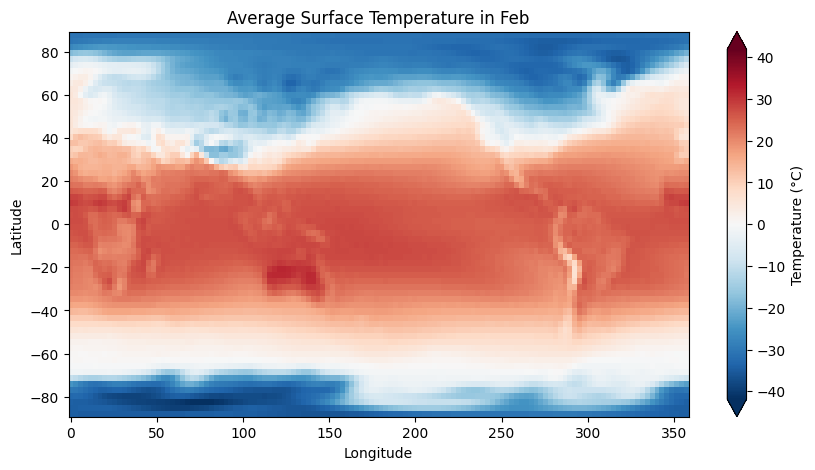

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
tsurf_feb.plot(ax=ax, extend='both', cbar_kwargs={'label': 'Temperature (°C)'})
ax.set_title('Average Surface Temperature in Feb')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

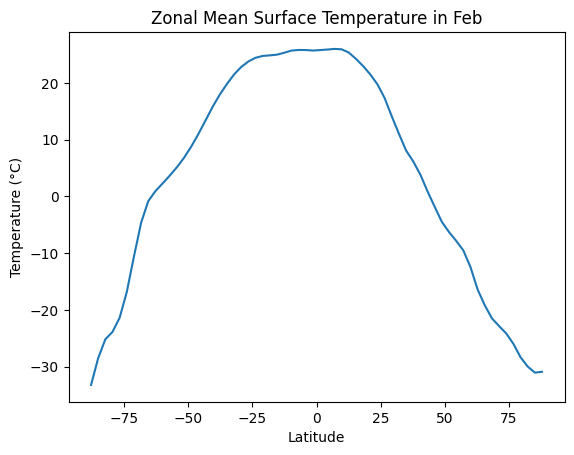

In [19]:
tsurf_feb_zonalmean = tsurf_feb.mean(dim='lon')

fig, ax = plt.subplots()
tsurf_feb_zonalmean.plot()
ax.set_title('Zonal Mean Surface Temperature in Feb')
ax.set_xlabel('Latitude')
ax.set_ylabel('Temperature (°C)')
plt.show()

In [20]:
# Need to set up vertical structure of background temp based on
# first sigma level input. Will need model vertical structure
# from subs1_utils

# Now generature the vertical strucuture of temperature
# will neeed model vertical structure (si(kmax))
#
delsig, si, sl, sikap, slkap, cth1, cth2, r1b, r2b = bscst(kmax)
#
#
temp_spec = torch.from_numpy(np.zeros((kmax,zw,mw)))
temp_gg = np.zeros((kmax,jmax,imax))
#
#   Radiative equilibrium temperature
#       varying surface temperature decreasing with
#       height with a lapse rate dTe/dz approx = -rlaps degrees/m
#       to a stratospheric temperature of tstrat
#
rlaps=6.8*1.0e-03
h0 = 8.2e+03
tstrat = 205.0 # fixed stratospheric temperature
#
#for ii in range(n_lamda):
#    temp_gg[kmax-1,:,ii] = tsurf_feb_zonalmean[:].values + 273.16 # Uncomment if
                                                        # only using zonal mean surface
                                                        # temperature
temp_gg[kmax-1,:,:] = tsurf_feb.values + 273.16 # Uncomment if using full surface 
                                                 # temperature
for k in np.arange(1, kmax, 1, dtype=int):
    temp_gg[k,:,:] = temp_gg[kmax-1,:,:] + h0*rlaps*np.log(sl[k])
#
temp_gg[:,:,imax-1] = temp_gg[:,:,0]
temp_gg = np.where(temp_gg < 205.0, 205.0, temp_gg)

Let's check out the interpolation results. We'll check the 21st level as an example. For reference, level 25 is the surface.

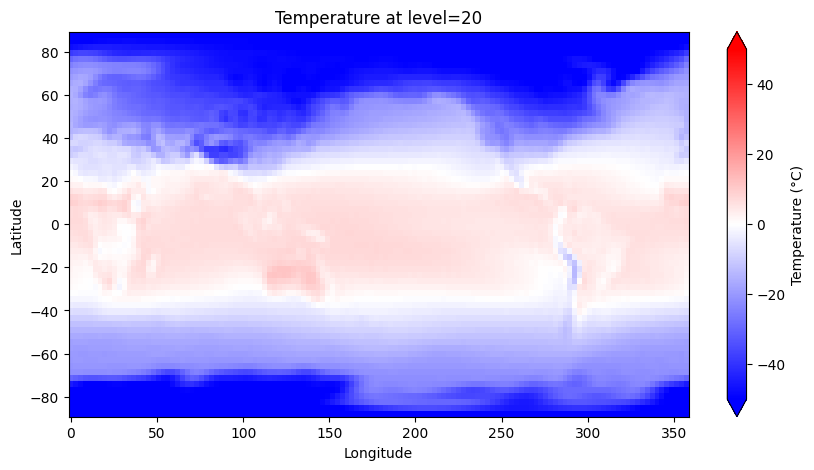

In [21]:
level_index = 20  # Index of the level to plot
temp_celsius = temp_gg[level_index, :, :] - 273.16

Lon, Lat = np.meshgrid(lons, lats)

fig, ax = plt.subplots(figsize=(10, 5))
cs = ax.pcolormesh(Lon, Lat, temp_celsius, cmap='bwr', vmin=-50, vmax=50)
cbar = fig.colorbar(cs, ax=ax, extend='both')
cbar.set_label('Temperature (°C)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Temperature at level={level_index}')
plt.show()

In [22]:
temp_coeffs = dsht(torch.from_numpy(temp_gg))

In [23]:
torch.save(temp_coeffs,'temp.spectral.pt')

# Grab the pressure data

In [24]:
#
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/surface_gauss/pres.sfc.mon.mean.nc'
Dps = xr.open_dataset(ftemp,autoclose=True)
Dps

<xarray.Dataset> Size: 66MB
Dimensions:  (lon: 192, lat: 94, time: 921)
Coordinates:
  * lon      (lon) float32 768B 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float32 376B 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2024-09-01
Data variables:
    pres     (time, lat, lon) float32 66MB ...
Attributes:
    Conventions:                     COARDS
    description:                     Data is from NCEP initialized reanalysis...
    platform:                        Model
    NCO:                             20121013
    history:                         Created 2011/06/28 by ESRL/PSD Web & Dat...
    title:                           monthly mean pres.sfc from the NCEP Rean...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.8.20
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    DODS_EXTRA.Unlimited_Dimension:  time

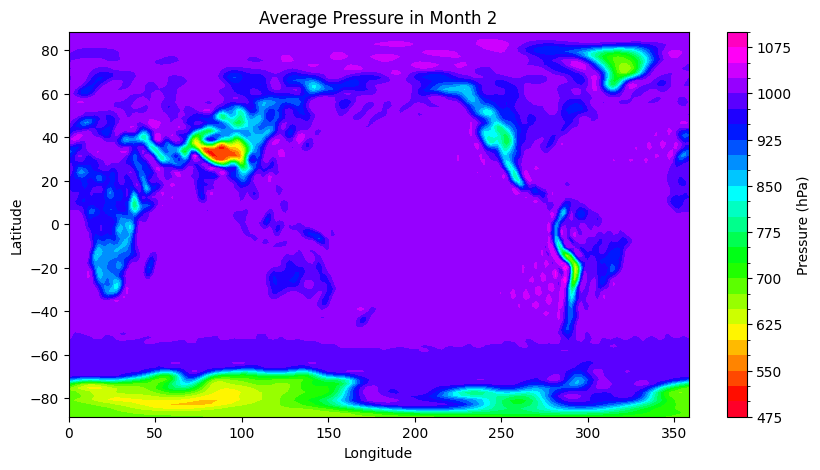

In [25]:
psmean = Dps.pres.groupby('time.month').mean(dim='time')

# Plotting the contourf for the selected month
fig, ax = plt.subplots(figsize=(10, 5))
contour = (psmean[month]/100).plot.contourf(ax=ax, cmap='gist_rainbow', levels=30, add_colorbar=False)  # Adjust levels as needed
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Pressure (hPa)')  # Pressure in hPa (convert from Pa)
ax.set_title(f'Average Pressure in Month {month+1}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

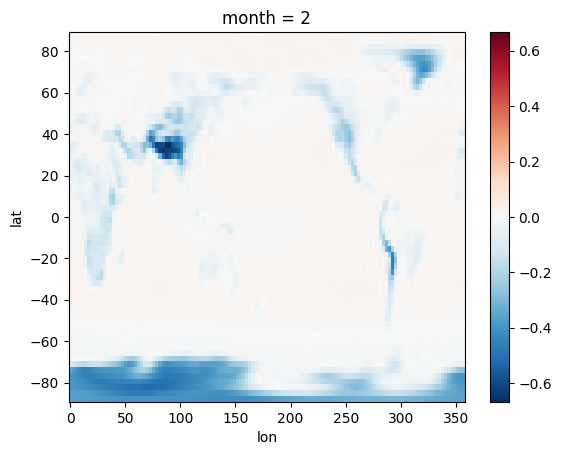

In [26]:
# convert to log of pressure
lnps = np.log(psmean[month]/(1000*100))

# Then interpolate to Gaussian grid
#
regridder_lnps = xe.Regridder(lnps,dlatlon,'bilinear')
#
lnps_feb = regridder_lnps(lnps)
lnps_feb[:,imax-1] = lnps_feb[:,imax-2]
lnps_feb.plot()
#

In [27]:
lnps_coeffs = dsht(torch.from_numpy(lnps_feb.values))
torch.save(lnps_coeffs,'lnps.spectral.pt')

# Grab the wind data

In [28]:
def press_to_sig(kmax,imax,jmax,press_data,press_levels,ps,slmodel,kmax_model):
    # 
    # first convert pressure data to sigma using ps
    #
    sig_levels = torch.zeros((kmax,jmax,imax),dtype=torch.float64) # sigma levels of input data
    sig_data = torch.zeros((kmax_model,jmax,imax),dtype=torch.float64) # output on model sigma levels
    slmap = torch.zeros((kmax_model,jmax,imax),dtype=torch.float64) # model sigma levels but for all j & i
    for k in range(kmax):
        sig_levels[k,:,:] = press_levels[k]/ps[:,:] # sig_levels depends on k,j & i
    for k in range(kmax_model):
        slmap[k,:,:] = torch.tensor(slmodel[k]) 
    #
    # now at each j & i to interpolate to the appropriate model sigma level
    # Use log(sig) for interpolation
    #
    for isig in range(kmax_model):
        for ipress in np.arange(kmax-1, -1, -1, dtype=int):
            foo_up = torch.gt(slmap[isig],sig_levels[ipress-1])
            foo_dn = torch.lt(slmap[isig],sig_levels[ipress])
            # test if appropriate press level found
            foo_up = 1*foo_up
            foo_dn = 1*foo_dn
            foo = foo_up + foo_dn
            found = ( foo == 2 )
            found = 1*found
            ### found = 1 level found ; found = 0 level not found
            denom = torch.log(sig_levels[ipress])\
                            - torch.log(sig_levels[ipress-1])
            numer1 = torch.log(sig_levels[ipress])\
                            - torch.log(slmap[isig])
            numer2 = torch.log(slmap[isig])\
                            - torch.log(sig_levels[ipress-1])
            foo = numer1*press_data[ipress-1]/denom + numer2*press_data[ipress]/denom
            sig_data[isig] = found*(foo) + (1-found)*sig_data[isig]
    #
    #
    # Need to check if model sigma level is below reanalysis lowest sigma level
    #
    for isig in range(kmax_model):
        foo_dn = torch.gt(slmap[isig],sig_levels[kmax-1])
        foo_dn = 1*foo_dn
        sig_data[isig] = foo_dn*press_data[kmax-1] + (1-foo_dn)*sig_data[isig]
    #
    #
    #
    # Need to check if model sigma level is above reanalysis highest sigma level
    #
    for isig in range(kmax_model):
        foo_up = torch.lt(slmap[isig],sig_levels[0])
        foo_up = 1*foo_up
        sig_data[isig] = foo_up*press_data[0] + (1-foo_up)*sig_data[isig]
    #
    return sig_data

In [29]:
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/pressure/vwnd.mon.mean.nc'
Dvwnd = xr.open_dataset(ftemp,autoclose=True)
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/pressure/uwnd.mon.mean.nc'
Duwnd = xr.open_dataset(ftemp,autoclose=True)
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/pressure/air.mon.mean.nc'
Dair = xr.open_dataset(ftemp,autoclose=True)
uwnd_clim = Duwnd.uwnd.groupby('time.month').mean(dim='time')
vwnd_clim = Dvwnd.vwnd.groupby('time.month').mean(dim='time')
air_clim = Dair.air.groupby('time.month').mean(dim='time')
obs_levels = np.flipud(Dair['level'].values)
kobs = np.size(obs_levels)

# Interpolate u & v to Gaussian Grid
#
lnps_feb = disht(lnps_coeffs) # inverse tranform applied here to limit
                             # unresolved scales
ps_feb = (torch.exp(lnps_feb)*1000.0) # surface pressure in mb on Gaussian grid
#
#
regridder_oi2 = xe.Regridder(Duwnd.uwnd,dlatlon,'bilinear')
upress_gg = torch.zeros((kobs,jmax,imax),dtype=torch.float64)
vpress_gg = torch.zeros((kobs,jmax,imax),dtype=torch.float64)
airpress_gg = torch.zeros((kobs,jmax,imax),dtype=torch.float64)
for k in range(kobs):
    upress_gg[kobs-k-1] = torch.from_numpy((regridder_oi2(uwnd_clim[month,k])).values)
    upress_gg[kobs-k-1,:,imax-2] = upress_gg[kobs-k-1,:,imax-3]
    upress_gg[kobs-k-1,:,imax-1] = upress_gg[kobs-k-1,:,imax-2]
    upress_gg[kobs-k-1,:,0] = upress_gg[kobs-k-1,:,1]
    vpress_gg[kobs-k-1] = torch.from_numpy((regridder_oi2(vwnd_clim[month,k])).values)
    vpress_gg[kobs-k-1,:,imax-2] = vpress_gg[kobs-k-1,:,imax-3]
    vpress_gg[kobs-k-1,:,imax-1] = vpress_gg[kobs-k-1,:,imax-2]
    vpress_gg[kobs-k-1,:,0] = vpress_gg[kobs-k-1,:,1]
    airpress_gg[kobs-k-1] = torch.from_numpy((regridder_oi2(air_clim[month,k])).values) + 273.16
    airpress_gg[kobs-k-1,:,imax-2] = airpress_gg[kobs-k-1,:,imax-3]
    airpress_gg[kobs-k-1,:,imax-1] = airpress_gg[kobs-k-1,:,imax-2]
    airpress_gg[kobs-k-1,:,0] = airpress_gg[kobs-k-1,:,1]
#
#
# Interpolate from Pressure to Sigma Levels
#
usig_gg = press_to_sig(kobs,imax,jmax,upress_gg,obs_levels,ps_feb,sl,kmax)
vsig_gg = press_to_sig(kobs,imax,jmax,vpress_gg,obs_levels,ps_feb,sl,kmax)
tsig_gg = press_to_sig(kobs,imax,jmax,airpress_gg,obs_levels,ps_feb,sl,kmax)
tsig_gg = torch.where(tsig_gg < 205.0, 205.0, tsig_gg) ### This probably can be removed
                                                    ### with improved vertical resolution
#
#
# Need to apply forward and backward spectral transform to ensure that
# there is no unresolved forcing from the prescribed background state
#
tmpspec = dsht(usig_gg)
usig_gg = disht(tmpspec)
tmpspec = dsht(vsig_gg)
vsig_gg = disht(tmpspec)
tmpspec = dsht(tsig_gg)
tsig_gg = disht(tmpspec)
#
# convert u & v into spectral vort & divergence
#
zmn,dmn = vortdivspec(vsht,usig_gg,vsig_gg,kmax,mw,zw)
#
# Transform Spectral Vorticity and Divergence to Gaussian Grid
#
vortsig_gg = disht(zmn) ### This is relative vorticity
divsig_gg = disht(dmn)
#
#
# Now write climo data
#
torch.save(vortsig_gg,'vortsig.ggrid.pt')
torch.save(divsig_gg,'divsig.ggrid.pt')
#

# Prescribe Heating (optional)

In [30]:
ftemp = 'http://psl.noaa.gov/thredds/dodsC/Datasets/cmap/enh/precip.mon.mean.nc'
Dprec = xr.open_dataset(ftemp,autoclose=True)
Dprec

<xarray.Dataset> Size: 23MB
Dimensions:  (lat: 72, lon: 144, time: 549)
Coordinates:
  * lat      (lat) float32 288B 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 576B 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-09-01
Data variables:
    precip   (time, lat, lon) float32 23MB ...
Attributes: (12/13)
    Conventions:                     COARDS
    title:                           CPC Merged Analysis of Precipitation (in...
    platform:                        Analyses
    source:                          ftp ftp.cpc.ncep.noaa.gov precip/cmap/mo...
    dataset_title:                   CPC Merged Analysis of Precipitation
    documentation:                   https://www.esrl.noaa.gov/psd/data/gridd...
    ...                              ...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    version:                         V2410
    history:                         update 10/2024 V2410
    data_modified:                   2024-10-10
    DODS_EXTRA.Unlimited_Dimension:  time

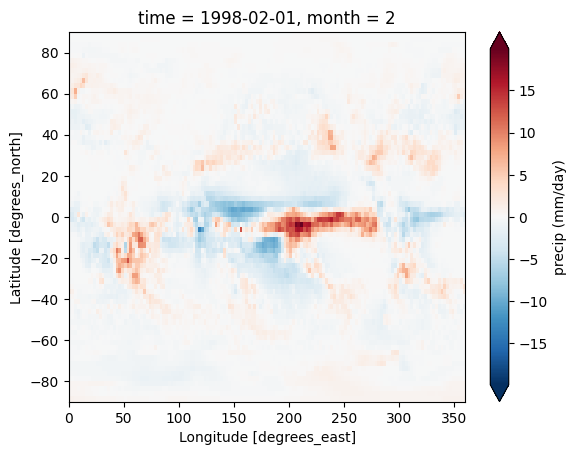

In [31]:
# Calculate climatology and anomalies
prec_clim = Dprec.precip.groupby('time.month').mean(dim='time')
prec_anom = Dprec.precip.groupby('time.month') - prec_clim
#
# ENSO Warm years
wyrs = ['1983','1987','1988','1992','1995','1998','2003','2005','2007','2010','2015','2016','2019']
wyrs = ['1998','1998','1998','1998','1998','1998','1998','1998','1998','1998','1998','1998','1998']
anom = prec_anom[0]*0.0

# select the month of choice from each year specified
for k in range(len(wyrs)):
    #anom = anom + prec_anom.sel(time=slice(wyrs[k]+'-01-01',wyrs[k]+'-03-01')).mean(dim='time')
    anom = anom + prec_anom.sel(time=wyrs[k]+'-02-01') # select Feb from each warm year
rain_anom = anom/len(wyrs)
rain_anom.plot(extend='both', cbar_kwargs={'label': 'precip (mm/day)'})

In [32]:
# Convert rainfall anomaly into a heating rate that can be
# applied to the temperature equation (i.e., Q/Cp) and distribute
# in the vertical
#
vert_struc = np.zeros(kmax)       # whatever user wants
#                                 kmax is lowest level and
#                                 0 is the upper most level of
#                                 the atmosphere
heat = torch.zeros((kmax,jmax,imax),dtype=torch.float64)
#
if (kmax == 11):
    vert_struc[0] = 0.0
    vert_struc[1] = 0.1
    vert_struc[2] = 0.2
    vert_struc[3] = 1.5
    vert_struc[4] = 1.9
    vert_struc[5] = 1.5
    vert_struc[6] = 0.9
    vert_struc[7] = 0.5
    vert_struc[8] = 0.2
    vert_struc[9] = 0.1
    vert_struc[10] = 0.0
#
if (kmax == 26):
    vert_struc[0] = 0.0
    vert_struc[1] = 0.0
    vert_struc[2] = 0.0
    vert_struc[3] = 0.0
    vert_struc[4] = 0.0
    vert_struc[5] = 0.25
    vert_struc[6] = 0.5
    vert_struc[7] = 0.75
    vert_struc[8] = 1.0
    vert_struc[9] = 1.5
    vert_struc[10] = 1.75
    vert_struc[11] = 1.75
    vert_struc[12] = 1.75
    vert_struc[13] = 2.0
    vert_struc[14] = 2.0
    vert_struc[15] = 2.0
    vert_struc[16] = 2.0
    vert_struc[17] = 1.75
    vert_struc[18] = 1.75
    vert_struc[19] = 1.5
    vert_struc[20] = 1.25
    vert_struc[21] = 0.75
    vert_struc[22] = 0.5
    vert_struc[23] = 0.25
    vert_struc[24] = 0.0
    vert_struc[25] = 0.0
#
# Need to ensure that vertical integral normalizes to 1.0
rnorm = (vert_struc*delsig).sum()
vert_struc = vert_struc/rnorm
#
# interpolate to Gaussian grid
#
regridder_oi2 = xe.Regridder(rain_anom,dlatlon,'bilinear')
#
tmp = regridder_oi2(rain_anom)
tmp = np.where(tmp < 0.0, 0.0, tmp)
#
dheat = xr.Dataset({'heat': (['lat','lon'],tmp)}, 
                        coords={'lat': lats, 'lon': lons})
globz = dheat.heat.mean(dim='lon')
globm = globz.mean(dim='lat')
tmp = (dheat.heat - globm).values
tmp_hold = tmp
#
#
# convert to heating and multiple by vertical structure
#
Lv = 2.5e+06
rhow = 1000.0
Cp = 1005.0
Ps = 101325.0
grav = 9.8
beta = (Lv*rhow/Cp)*(grav/Ps)/(1000.0*86400.0)
tropics = np.exp((-Lat*Lat)/1000.0) # limit forcing to tropics
tmp = tropics*tmp
#
# Transform forward and backward to reduce forcing at unresolved scales
#
tmpspec = dsht(torch.from_numpy(tmp))
tmp = disht(tmpspec)
#
for k in range(kmax):
    heat[k,:,:] = (tmp[:,:]*vert_struc[k]*beta) # in K/sec

In [33]:
#
torch.save(heat,'heat.ggrid.pt') # South-to-North same as topog data
#

# Explore

Now that you've seen how to create the model inputs, try creating your own experiment. Some ideas include changing the:
* **Topography**
    * What happens if you remove or alter the topography?
* **Heating**
    * What other kinds of phenomena create sensible and latent heat anomalies? 
* **Forcing location**
    * The model is set to tropical forcings to observe teleconnections in the mid-latitudes. What if you alter where the forcing is applied?
* **Lapse rate or stratospheric temperature**
    * Does it break the model or alter the climate?
* **Background state**
    * Instead of reanalysis data from the last 80 years, how might forcing effects change if the model were nudged back to a different mean climate state?
* **Resolution**
    * What happens if you change the vertical and horizontal resolutions?